In [1]:
import torch
import scipy
from scipy import ndimage
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
import pandas as pd
from pyparsing import *
import numpy as np
import sklearn.preprocessing
from sklearn import datasets, linear_model

import torch,torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np

from torchvision.datasets import MNIST
import torchvision.transforms as transforms

# Solar Irrad

In [2]:
def load_data():
    N=391
    df=pd.read_csv('Sol_Irrad.txt', sep=',')

    data = np.zeros(shape=(N, 2))
    mod_name = Word(nums)
    mod_dots = Word(nums + '.')
    parse_module = mod_dots + mod_dots + mod_dots

    for i in range(df.shape[0]):
        b = parse_module.parseString(df.values[i][0])
        data[i, 0] = np.float(b[2])
        data[i, 1] = np.float(b[0])
    
    return data

def preproc(data):
    def inv_preproc(x, y):
        data = np.array([y, x]).T
        data = scaler.inverse_transform(data)
        x = data[:, 1]
        y = data[:, 0]
        return x, y
    
    data = data.copy()
    
    train_data = np.asarray(data[:15, :].tolist() + data[35:95, :].tolist() + data[115:175, :].tolist() \
                          + data[195:255, :].tolist() + data[275:335, :].tolist() + data[355:, :].tolist())
    test_data  = np.asarray(data[15:35, :].tolist() + data[95:115, :].tolist() + data[175:195, :].tolist() \
                          + data[255:275, :].tolist() + data[335:355, :].tolist())
    
    
    scaler = sklearn.preprocessing.StandardScaler(copy=True, with_mean=True, with_std=True)
    scaler.fit(train_data)
    
    train_data = scaler.transform(train_data)
    test_data = scaler.transform(test_data)
    
    x_train = train_data[:, 1]
    y_train = train_data[:, 0]
    x_test = test_data[:, 1]
    y_test = test_data[:, 0]
    
    return (x_train, y_train, x_test, y_test), inv_preproc

data = load_data()

(x_train, y_train, x_test, y_test), inv_preproc = preproc(data)

Results:


(0.31352245579652493, 0.005533243998834429)

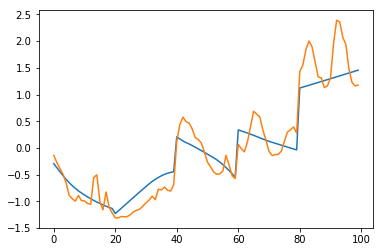

In [3]:
network = torch.load('solarirrad_linear_relu_network.p', map_location='cpu')

plt.plot(network(Variable(torch.FloatTensor(x_test)).unsqueeze(1)).data.numpy())
plt.plot(y_test)

network.train()
X_test = Variable(torch.FloatTensor(x_test)).unsqueeze(1)

data_RMSE = []
for i in range(100):
    prediction = network(X_test)
    MSE = mean_squared_error(prediction.data.numpy().reshape(-1), y_test)
    data_RMSE.append(np.sqrt(MSE))
    
data_RMSE = np.array(data_RMSE)

print('Results:')
data_RMSE.mean(), data_RMSE.std()

# CO2

In [4]:
def load_data():
    
    N = 721
    df=pd.read_csv('Mauna_Loa_CO2.csv', sep=',')
    
    data = np.zeros(shape=(N, 2))
    mod_name = Word(nums)
    mod_dots = Word(nums + '.' + '-')
    parse_module = mod_name + mod_name + mod_dots + mod_dots + mod_dots

    for i in range(df.shape[0]):
        b = parse_module.parseString(df.values[i][0])
        data[i, 0] = np.float(b[4])
        data[i, 1] = np.float(b[2])
    
    return data


def preproc(data):
    def inv_preproc(x, y):
        data = np.array([y,x]).T
        data = scaler.inverse_transform(data)
        x = data[:,1]
        y = data[:,0]
        y_trend = regr.predict(x[:,np.newaxis])
        y  = y + y_trend
        return x, y
    
    data = data.copy()
    train = data[:500, :]
    test = data[500:, :]
    
    x_train = train[:, 1]
    y_train = train[:, 0]
    x_test = test[:, 1]
    y_test = test[:, 0]
    
    regr = linear_model.LinearRegression()
    regr.fit(x_train[:,np.newaxis], y_train)
    
    y_train_trend = regr.predict(x_train[:,np.newaxis])
    y_train  = y_train - y_train_trend
    
    y_test_trend = regr.predict(x_test[:,np.newaxis])
    y_test  = y_test - y_test_trend

    
    train[:,0] = y_train
    test[:,0] = y_test
    
    scaler = sklearn.preprocessing.StandardScaler(copy=True, with_mean=True, with_std=True)
    scaler.fit(train)

    train = scaler.transform(train)
    test = scaler.transform(test)
    
    x_train = train[:, 1]
    y_train = train[:, 0]
    x_test = test[:, 1]
    y_test = test[:, 0]
    
    return (x_train, y_train, x_test, y_test),inv_preproc

In [5]:
data = load_data()

(x_train, y_train, x_test, y_test),inv_preproc = preproc(data)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


Results:


(1.4486546174814743, 0.03768801935047343)

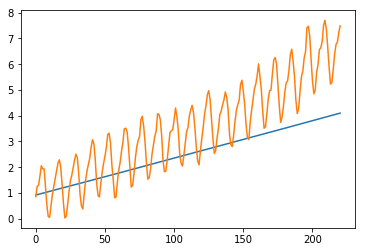

In [6]:
# 1
network = torch.load('linear_network.p', map_location='cpu')

plt.plot(network(Variable(torch.FloatTensor(x_test)).unsqueeze(1)).data.numpy())
plt.plot(y_test)

network.train()
X_test = Variable(torch.FloatTensor(x_test)).unsqueeze(1)

data_RMSE = []
for i in range(100):
    prediction = network(X_test)
    MSE = mean_squared_error(prediction.data.numpy().reshape(-1), y_test)
    data_RMSE.append(np.sqrt(MSE))
    
data_RMSE = np.array(data_RMSE)
print('Results:')
data_RMSE.mean(), data_RMSE.std()

Results:


(1.1903737199950701, 0.027731091659463036)

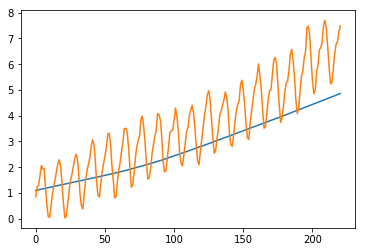

In [7]:
# 2
network = torch.load('linear_relu_network.p', map_location='cpu')

plt.plot(network(Variable(torch.FloatTensor(x_test)).unsqueeze(1)).data.numpy())
plt.plot(y_test)

network.train()
X_test = Variable(torch.FloatTensor(x_test)).unsqueeze(1)

data_RMSE = []
for i in range(100):
    prediction = network(X_test)
    MSE = mean_squared_error(prediction.data.numpy().reshape(-1), y_test)
    data_RMSE.append(np.sqrt(MSE))
    
data_RMSE = np.array(data_RMSE)
print('Results:')
data_RMSE.mean(), data_RMSE.std()

Results:


(2.9323152923225053, 0.00833550311097173)

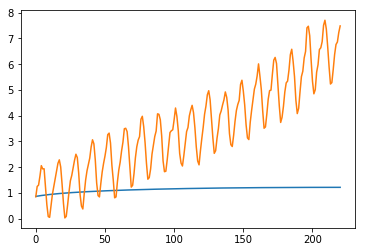

In [8]:
# 3
network = torch.load('linear_tanh_network.p', map_location='cpu')

plt.plot(network(Variable(torch.FloatTensor(x_test)).unsqueeze(1)).data.numpy())
plt.plot(y_test)

network.train()
X_test = Variable(torch.FloatTensor(x_test)).unsqueeze(1)

data_RMSE = []
for i in range(100):
    prediction = network(X_test)
    MSE = mean_squared_error(prediction.data.numpy().reshape(-1), y_test)
    data_RMSE.append(np.sqrt(MSE))
    
data_RMSE = np.array(data_RMSE)
print('Results:')
data_RMSE.mean(), data_RMSE.std()